In [31]:
%run tools.ipynb

In [49]:
# yield

selected_crops = ['maize', 'rice_major', 'rice_second', 'soybean', 'wheat_spring', 'wheat_winter']

fname = "../data/gdhy_v1.2_v1.3_20190128/" + selected_crops[0] + "/yield_2016.nc4"
ds = xr.open_dataset(fname)
crop_yield = ds['var']


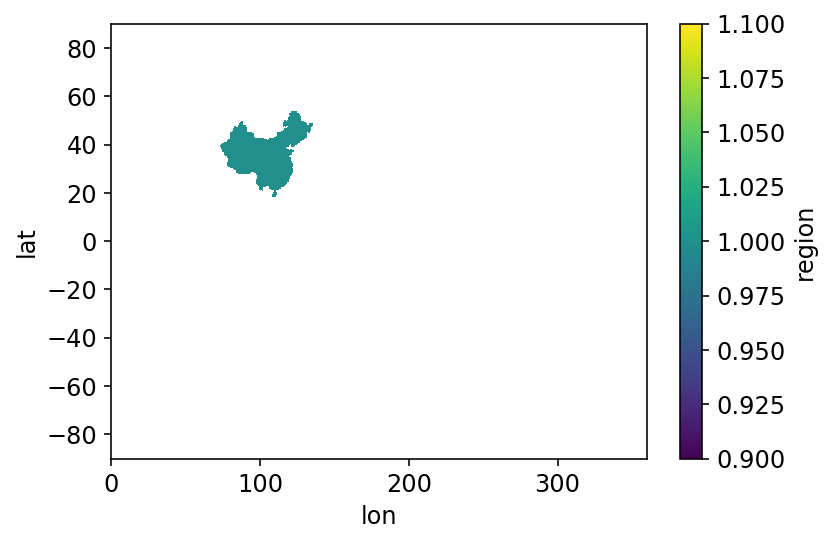

In [33]:
# make China mask
dr_tmp = ds['var']

mask1 = regionmask.defined_regions.natural_earth.countries_110.mask(dr_tmp)
country_mean = dr_tmp.groupby(mask1).mean('stacked_lat_lon')
names = regionmask.defined_regions.natural_earth.countries_110[country_mean.region.values].names

names.index('China') # index of China, 139

mask_china = mask1.where(mask1 == 139) - 138 # keep China mask, China = 1, Other = 0

mask_china.plot()

In [50]:
yield_china = crop_yield * mask_china

In [35]:
# plot XY range
lat1 = 18
lat2 = 55
lon1 = 72
lon2 = 135

In [36]:
# China provincial borders 
with open(r'/Users/mehliyarsadiq/Desktop/ozone_crop_China/data/CN-border-La.dat') as src:
    context = ''.join([line for line in src if not line.startswith('#')])
    blocks = [cnt for cnt in context.split('>') if len(cnt) > 0]
    borders = [np.fromstring(block, dtype=float, sep=' ') for block in blocks]


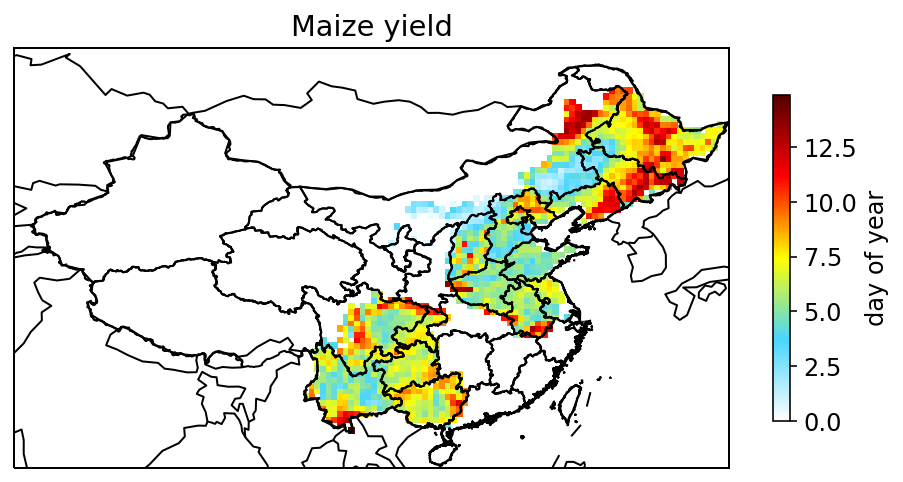

In [51]:
import cartopy.feature as cfeature

fig = plt.figure(figsize=[8, 6])
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)
ax.coastlines()
yield_china.plot(ax = ax,
                  transform=ccrs.PlateCarree(), 
                  cmap=WhGrYlRd, 
                  #vmin = 200,
                  #vmax = 320,
                  cbar_kwargs={'shrink': 0.5, 'label': 'day of year'})

ax.set_xlim(lon1,lon2)
ax.set_ylim(lat1,lat2)
ax.set_title('Maize yield')
ax.add_feature(cfeature.BORDERS)

# China borders
for line in borders:
    ax.plot(line[0::2], line[1::2], '-', lw=1, color='k',transform=ccrs.Geodetic())

out_dir = '/Users/mehliyarsadiq/Desktop/ozone_crop_China/figures/'
#fig.savefig(out_dir + 'harvest_date_China.png', dpi = 300, bbox_inches = "tight")


In [52]:
# save all of them as one netcdf
ds_out = yield_china.to_dataset(name = selected_crops[0])

for i in range(1, len(selected_crops)):
    fname = "../data/gdhy_v1.2_v1.3_20190128/" + selected_crops[i] + "/yield_2016.nc4"
    ds = xr.open_dataset(fname)
    crop_yield = ds['var']
    
    yield_china = crop_yield * mask_china
    
    ds_out[selected_crops[i]] = yield_china

In [53]:
ds_slice = ds_out.sel(lat = slice(lat1, lat2), lon = slice(lon1, lon2))

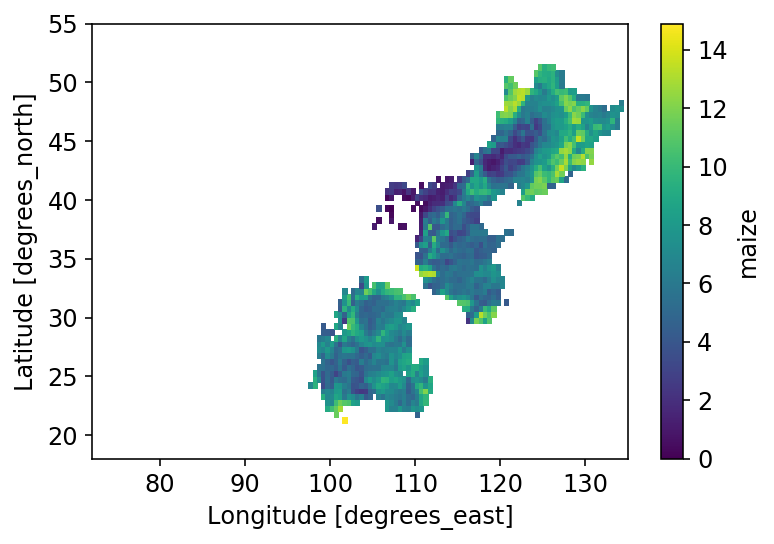

In [54]:
ds_slice[selected_crops[0]].plot()

In [60]:
selected_crops

['maize',
 'rice_major',
 'rice_second',
 'soybean',
 'wheat_spring',
 'wheat_winter']

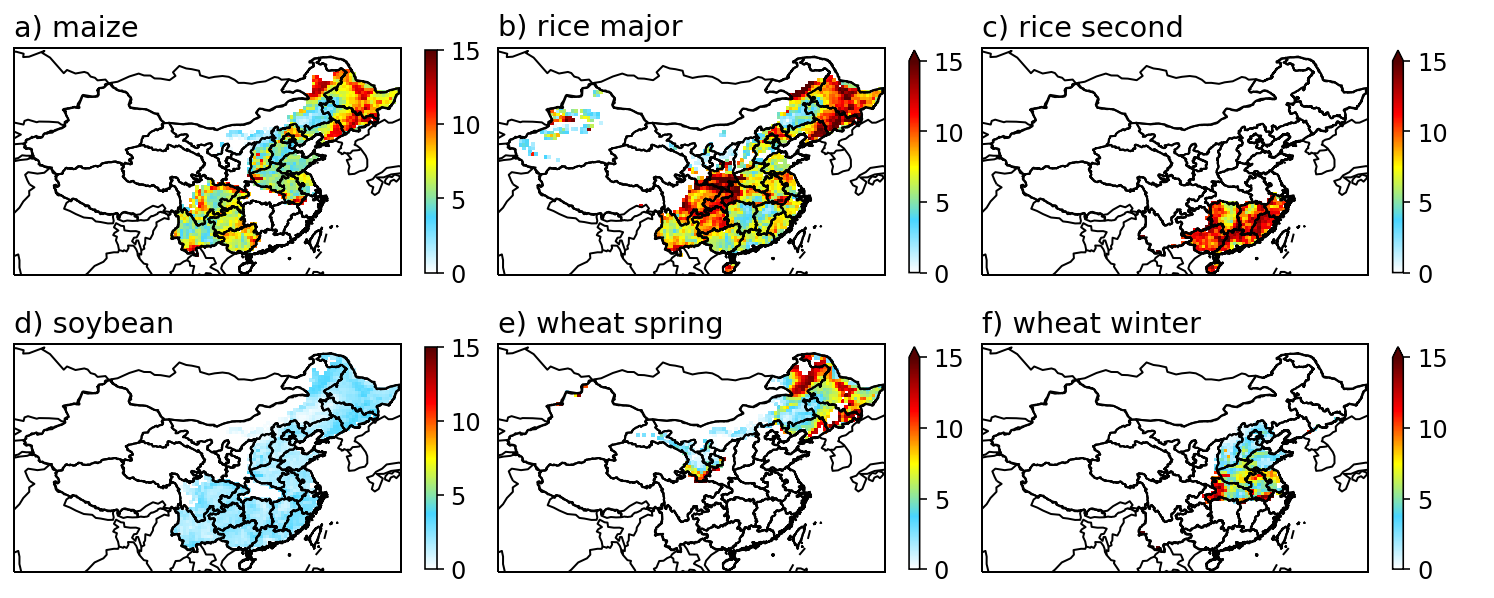

In [62]:

titles = ['a) maize', 'b) rice major', 'c) rice second',
 'd) soybean', 'e) wheat spring', 'f) wheat winter']

# figure 1, distribution
fig, axes = plt.subplots(2, 3, 
                             figsize=[13, 5], 
                             subplot_kw={'projection': ccrs.PlateCarree()},
                             gridspec_kw={'hspace': 0.2, 'wspace': 0})
axes = axes.ravel()

for i in range(len(selected_crops)):
    axes[i].coastlines()
    ds_slice[selected_crops[i]].plot(ax = axes[i],
                      transform=ccrs.PlateCarree(), 
                      cmap=WhGrYlRd, 
                      vmin = 0,
                      vmax = 15,
                      cbar_kwargs={'shrink': 0.9, 'label': ' '})

    axes[i].set_xlim(lon1,lon2)
    axes[i].set_ylim(lat1,lat2)
    axes[i].set_title(titles[i], loc = 'left')
    axes[i].add_feature(cfeature.BORDERS)

    # China borders
    for line in borders:
        axes[i].plot(line[0::2], line[1::2], '-', lw=1, color='k',transform=ccrs.Geodetic())

out_dir = '/Users/mehliyarsadiq/Desktop/ozone_crop_China/figures/'
fig.savefig(out_dir + 'crop_yield.png', dpi = 300, bbox_inches = "tight")
